## Week 4 : NLP Disaster Tweets Kaggle Mini-Project
Student, University of Colorado Boulder


## Step 1: Brief description of the problem and data

We are provided with tweets which are classified as 1 if they are about real disasters and 0 if they are not.  We will use these as training data.
Intent of the project is to build a machine learning model that predicts which tweets are about real disasters and which one’s aren’t.  We will develop this model and test them on the test data.

The details of the project is available in Kaggle competition https://www.kaggle.com/c/nlp-getting-started/overview


In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from copy import deepcopy

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

/Users/kkuruvad/Desktop/masters/UniversityOfColoradoBoulder/DTSA 5511 Introduction to Deep Learning/week4/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Data Extraction
User has to register on kaggle to get access to the dataset.  This data is expected to be stored in data/nlp-getting-started folder

In [2]:
data_path = 'data/nlp-getting-started/'
df_train = pd.read_csv(data_path+'train.csv')
df_test = pd.read_csv(data_path+'test.csv')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


There are total of 7613 rows with 5 columns.  2 columns are of integer type and 3 are of type object (string).  The id field is unique with values going from 0 to 7612.

In [3]:
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [5]:
df_test.info

<bound method DataFrame.info of          id keyword location  \
0         0     NaN      NaN   
1         2     NaN      NaN   
2         3     NaN      NaN   
3         9     NaN      NaN   
4        11     NaN      NaN   
...     ...     ...      ...   
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                   text  
0                    Just happened a terrible car crash  
1     Heard about #earthquake is different cities, s...  
2     there is a forest fire at spot pond, geese are...  
3              Apocalypse lighting. #Spokane #wildfires  
4         Typhoon Soudelor kills 28 in China and Taiwan  
...                                                 ...  
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...  
3259  Storm in RI worse than last hurricane. My city...  
3260  Green Line derailment in Chicago http://t.co/U...  
326

In [6]:
df_test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


We have 3263 rows of data in the test dataframe and the structure is similar to the training data without the target column

## Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Let us look at distribution of disaster vs not disaster tweets in the training data

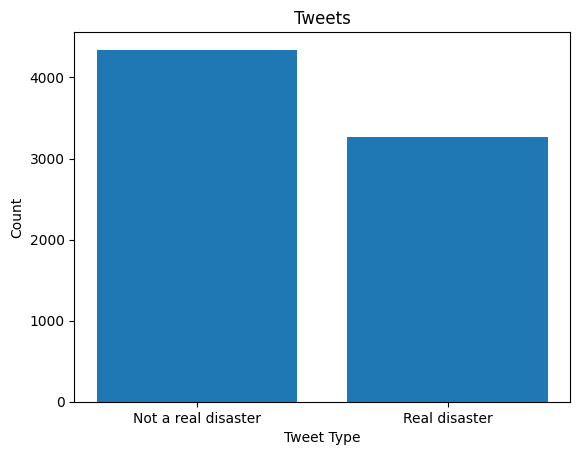

In [7]:
df_train['target'].plot.hist()

x = ["Not a real disaster", "Real disaster"]
y = [df_train['target'].value_counts()[0.0], df_train['target'].value_counts()[1.0]]
     
plt.bar(x, y)
plt.title("Tweets")
     
plt.xlabel("Tweet Type")
plt.ylabel("Count")
     
plt.show()

Let us look at the size of tweets

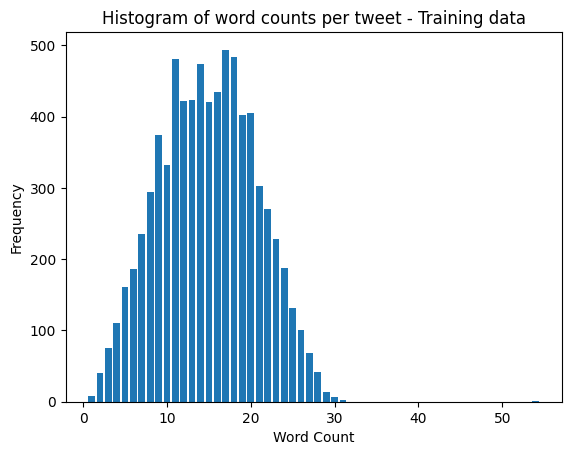

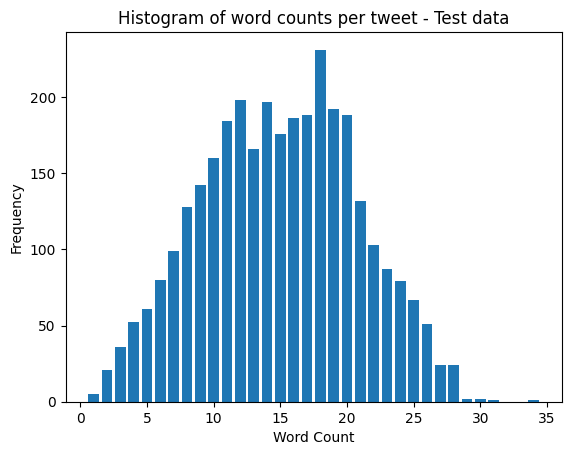

In [8]:
def histogram_of_word_counts(strings, df_type):
    counts = {}
    for string in strings:
        words = string.split(' ')
        length = len(words)
        if length not in counts:
            counts[length] = 0
        counts[length] += 1
        #if length > 50:
        #    print(f'{string}: {words}')

    word_counts = list(counts.keys())

    counts = list(counts.values())

    # Create the histogram.
    plt.bar(word_counts, counts)
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of word counts per tweet - {df_type} data")
    plt.show()

histogram_of_word_counts(df_train['text'], 'Training')
histogram_of_word_counts(df_test['text'], 'Test')

Let us look at some frequent words in the tweets

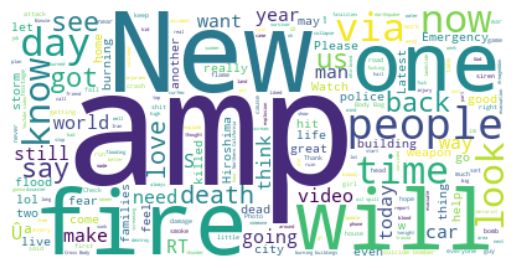

In [9]:
stopwords = set(STOPWORDS)
stopwords.update(['u', 't', 'https', 'co', 'Û_', 'Û'])
text = " ".join(review for review in df_train.text)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Cleaning
We dont need the id, keyword and location fields so we can drop those columns in training dataframe.  We need the id in test dataframe so we wont drop that.

In [10]:
df_train = df_train.drop(columns=['id', 'location', 'keyword'])
df_test = df_test.drop(columns=['location', 'keyword'])
df_train.info

<bound method DataFrame.info of                                                    text  target
0     Our Deeds are the Reason of this #earthquake M...       1
1                Forest fire near La Ronge Sask. Canada       1
2     All residents asked to 'shelter in place' are ...       1
3     13,000 people receive #wildfires evacuation or...       1
4     Just got sent this photo from Ruby #Alaska as ...       1
...                                                 ...     ...
7608  Two giant cranes holding a bridge collapse int...       1
7609  @aria_ahrary @TheTawniest The out of control w...       1
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1
7611  Police investigating after an e-bike collided ...       1
7612  The Latest: More Homes Razed by Northern Calif...       1

[7613 rows x 2 columns]>

## Step 3: Model Architecture
Before we start building tensorflow models, let us convert the data and pad if necessary.  We will use GloVe to process texts to matrix form (word embedding)

3a. Download the necessary GloVe zip file

In [26]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2024-04-10 10:18:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M   834KB/s    in 14m 26s 

2024-04-10 10:32:46 (972 KB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]



3b. Extract the zip file

In [18]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


3c. Form the GloVe word mappings.  Let us use the 100 dimension file.

In [11]:
def glove_word_mappings(filename):
    word_mapping = dict()
    with open(filename, 'r') as f:
        for line in f.readlines():
            try:
                words = line.split(' ')
                word_mapping[words[0]] = np.array(words[1:], dtype=float)
            except Exception as ex:
                print(f'failed to use {words[0]}: {ex}')
                break
    return word_mapping


glove_words = glove_word_mappings('glove.6B.100d.txt')
print(f'count of glove words {len(glove_words)}')

count of glove words 400000


3d. Download wordnet using nltk.  We will be using this for the tokenizer

In [12]:
nltk.download('wordnet')

regexp_tokenizer = nltk.RegexpTokenizer(r'\w+')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kkuruvad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


3e. Function to lemmatize the tweet/a given text.  We will only use the lemmatized token if it is present in GloVe

In [13]:

lemmatizer = WordNetLemmatizer()

def tweet_to_tokens(tweet):
    tokens = regexp_tokenizer.tokenize(tweet)
    tokens = [t.lower() for t in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return [t for t in lemmatized_tokens if t in glove_words]


3f. Function to convert the tokens into vectors

In [14]:
def tokens_to_vectors(tokens):
    vectors = list()
    for token in tokens:
        if token not in glove_words:
            continue
        vectors.append(glove_words[token])
    return np.array(vectors, dtype=float)

3g. Split input data into training (70%) and validation (30%)

In [15]:
m_df_train = df_train.sample(frac=1, random_state=142)
m_df_train.reset_index(drop=True, inplace=True)

train_validate_split = int(len(m_df_train)*0.7)

train, validate = m_df_train[:train_validate_split], m_df_train[train_validate_split:]
len(train), len(validate)

(5329, 2284)

3h. Convert the training, validation and test dataframes into tokens 

In [16]:
def dataframe_to_X_y(df):
    y = None
    if 'target' in df:
        y = df['target'].to_numpy().astype(int)        

    vectors = list()
    for tweet in df['text']:
        tokens = tweet_to_tokens(tweet)
        v = tokens_to_vectors(tokens)
        if v.shape[0] == 0:
            vectors.append(np.zeros(shape=(1,100)))
        else:
            vectors.append(v)
    return vectors, y

df_test.info()
X_train, y_train = dataframe_to_X_y(train)
X_val, y_val = dataframe_to_X_y(validate)
X_test,_ = dataframe_to_X_y(df_test)

print(f'len(X_train): {len(X_train)}, len(y_train): {len(y_train)}, len(X_val): {len(X_val)}, len(y_val): {len(y_val)}, len(X_test):{len(X_test)}')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB
len(X_train): 5329, len(y_train): 5329, len(X_val): 2284, len(y_val): 2284, len(X_test):3263


3i. Check for the maximum vectors size of the tweet in all the 3 dataframes (training, validation and test) .  We will use this later in padding

count    10876.000000
mean        15.636539
std          5.927161
min          1.000000
25%         12.000000
50%         16.000000
75%         20.000000
max         34.000000
dtype: float64

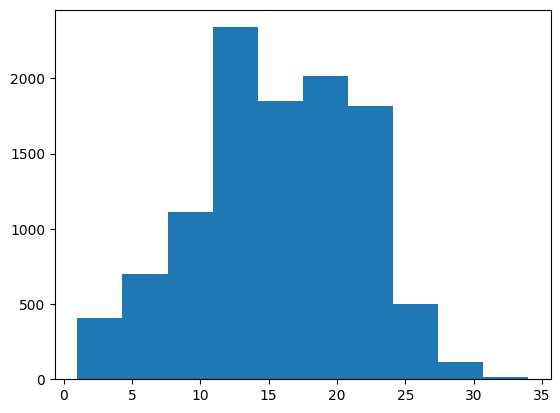

In [17]:
sequence_lengths = list()
for i in range(len(X_train)):
    sequence_lengths.append(len(X_train[i]))
for i in range(len(X_val)):
    sequence_lengths.append(len(X_val[i]))
for i in range(len(X_test)):
    sequence_lengths.append(len(X_test[i]))

plt.hist(sequence_lengths)
pd.Series(sequence_lengths).describe()

3j. Use the maximum size of vectors to determine padding.  We will round the value and consider 35 

In [18]:
def pad_X(X, length, dimension):
    X_copy = deepcopy(X)
    for i,x in enumerate(X):
        l = x.shape[0]
        padding = np.zeros(shape=(length-x.shape[0], dimension))
        X_copy[i] = np.concatenate([x, padding])
    return np.array(X_copy).astype(float)

#X_train.shape
X_train_pad = pad_X(X_train, 35, 100)
print(f'training: {X_train_pad.shape}')

X_val_pad = pad_X(X_val, 35, 100)
print(f'validation: {X_val_pad.shape}')

X_test_pad = pad_X(X_test, 35, 100)
print(f'test: {X_test_pad.shape}')

training: (5329, 35, 100)
validation: (2284, 35, 100)
test: (3263, 35, 100)


#### Models

Now that our data is converted, we can start with tensorflow models

After padding our X has shape of 35, 100.  So lets declare input layer of this shape
LSTM of 64 units is good enough in most cases.  So lets add that.  Let us also add a drop out layer with 0.2.

Let us repeat the same layers again and finally flatten and apply sigmoid activation since we want the output to be 0 or 1

In [19]:
model = Sequential([])

model.add(layers.Input(shape=(35,100)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

cp = ModelCheckpoint('tf_model/model_seq_1.keras', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['Accuracy', AUC(name='auc')])

model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - Accuracy: 0.5982 - auc: 0.6246 - loss: 0.6557 - val_Accuracy: 0.7609 - val_auc: 0.8161 - val_loss: 0.5218
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Accuracy: 0.7674 - auc: 0.8276 - loss: 0.5050 - val_Accuracy: 0.7763 - val_auc: 0.8482 - val_loss: 0.4837
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Accuracy: 0.7987 - auc: 0.8520 - loss: 0.4593 - val_Accuracy: 0.7973 - val_auc: 0.8635 - val_loss: 0.4514
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Accuracy: 0.8052 - auc: 0.8683 - loss: 0.4383 - val_Accuracy: 0.8074 - val_auc: 0.8687 - val_loss: 0.4409
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Accuracy: 0.8015 - auc: 0.8634 - loss: 0.4428 - val_Accuracy: 0.8008 - val_auc: 0.8709 - val_loss: 0.4419
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - Accuracy: 0.8143 - auc: 0.8781 - loss: 0.4189 - val_Accuracy: 0.8043 - val_auc: 0.8721 - val_loss: 0.4352
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━

Let us load the best model and run predictions on the test set

In [100]:
best_model = load_model('tf_model/model_seq_1.keras')

predictions = (best_model.predict(X_test_pad) > 0.5).astype(int)
predictions
output_df = pd.DataFrame(df_test['id'])
output_df['target'] = predictions
out = output_df.to_csv('Disaster_tweets_RNN_seq_1.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


The model got a score of 0.79773 which is not bad.
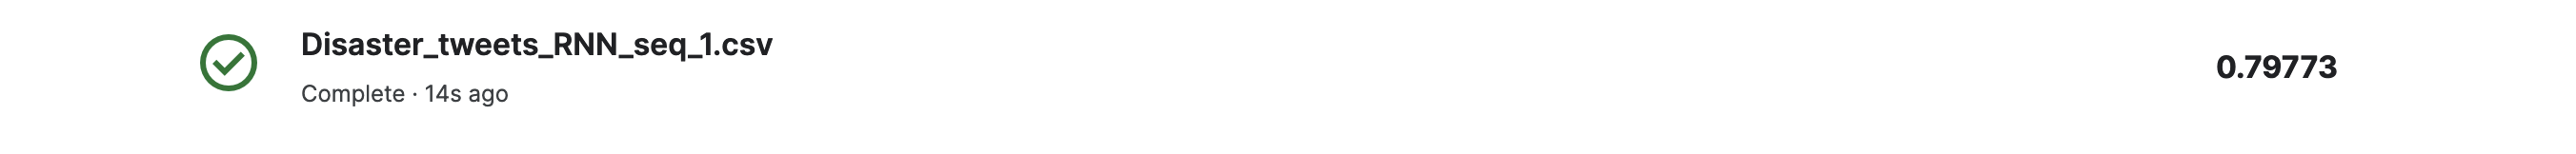

#### Parameter tuning

Let us see if we can get a better score.  We already know that the tweet 'target' - ie if a tweet is of a real disaster or not, is skewed with more zeros (not disaster) that ones (disaster).  Let us use the weights parameter of the fit to see if we can get better results

In [22]:
disaster_counts = pd.Series(df_train['target']).value_counts()
disaster_counts
weights = {0:disaster_counts.sum()/disaster_counts[0], 1:disaster_counts.sum()/disaster_counts[1]}
weights

{0: 1.753339474896361, 1: 2.3274228064811986}

In [102]:

model = Sequential([])

model.add(layers.Input(shape=(35,100)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

cp = ModelCheckpoint('tf_model/model.keras', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['Accuracy', AUC(name='auc')])

model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=20, callbacks=[cp], class_weight=weights)

Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - Accuracy: 0.6667 - auc: 0.7015 - loss: 1.3042 - val_Accuracy: 0.7487 - val_auc: 0.8175 - val_loss: 0.5237
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Accuracy: 0.7798 - auc: 0.8384 - loss: 0.9874 - val_Accuracy: 0.7785 - val_auc: 0.8495 - val_loss: 0.4775
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Accuracy: 0.7965 - auc: 0.8611 - loss: 0.9091 - val_Accuracy: 0.7885 - val_auc: 0.8631 - val_loss: 0.4644
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Accuracy: 0.7958 - auc: 0.8635 - loss: 0.9012 - val_Accuracy: 0.7973 - val_auc: 0.8647 - val_loss: 0.4458
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - Accuracy: 0.8015 - auc: 0.8702 - loss: 0.8887 - val_Accuracy: 0.7999 - val_auc: 0.8683 - val_loss: 0.4511
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - Accuracy: 0.8151 - auc: 0.8851 - loss: 0.8364 - val_Accuracy: 0.7964 - val_auc: 0.8695 - val_loss: 0.4529
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━

In [103]:
best_model = load_model('tf_model/model.keras')

predictions = (best_model.predict(X_test_pad) > 0.5).astype(int)
predictions
output_df = pd.DataFrame(df_test['id'])
output_df['target'] = predictions
out = output_df.to_csv('Disaster_tweets_RNN.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


The model got a score of 0.80416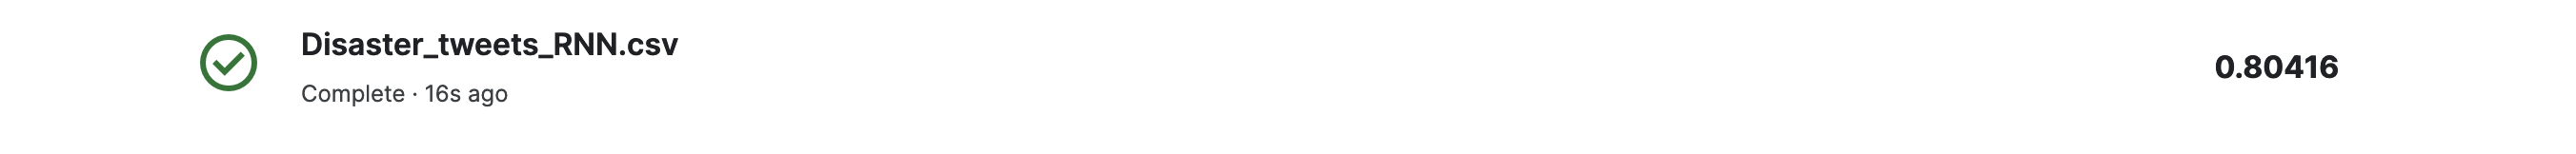

In [104]:
model = Sequential([])

model.add(layers.Input(shape=(35,100)))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

cp = ModelCheckpoint('tf_model/model_128.keras', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['Accuracy', AUC(name='auc')])

model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=50, callbacks=[cp], class_weight=weights)

best_model = load_model('tf_model/model_128.keras')

predictions = (best_model.predict(X_test_pad) > 0.5).astype(int)
predictions
output_df = pd.DataFrame(df_test['id'])
output_df['target'] = predictions
out = output_df.to_csv('Disaster_tweets_RNN_128.csv', index=False)

Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - Accuracy: 0.7043 - auc: 0.7413 - loss: 1.2223 - val_Accuracy: 0.7662 - val_auc: 0.8412 - val_loss: 0.4967
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - Accuracy: 0.7967 - auc: 0.8566 - loss: 0.9263 - val_Accuracy: 0.7863 - val_auc: 0.8581 - val_loss: 0.4636
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - Accuracy: 0.8006 - auc: 0.8637 - loss: 0.9001 - val_Accuracy: 0.7938 - val_auc: 0.8662 - val_loss: 0.4582
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - Accuracy: 0.8125 - auc: 0.8760 - loss: 0.8635 - val_Accuracy: 0.8012 - val_auc: 0.8689 - val_loss: 0.4436
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - Accuracy: 0.8211 - auc: 0.8859 - loss: 0.8327 - val_Accuracy: 0.8078 - val_auc: 0.8704 - val_loss: 0.4360
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - Accuracy: 0.8167 - auc: 0.8854 - loss: 0.8302 - val_Accuracy: 0.8039 - val_auc: 0.8713 - val_loss: 0.4360
Epoch 7/50
167/167 ━━━━━━━━━━

This model with 128 units and 50 epochs doesnt perform any better than the model with 64 units and 20 epochs. 
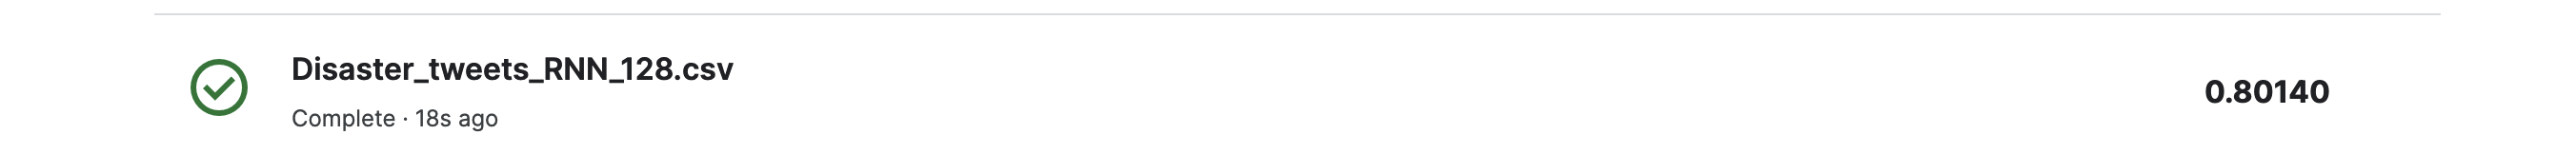

Changing the learning rate to 0.00001 (not captured here) also didnt help with increasing the accuracy

Let us replace LSTM with GRU

In [108]:
model = Sequential([])
model.add(layers.Input(shape=(35,100)))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

cp = ModelCheckpoint('tf_model/model_gru.keras', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics=['Accuracy'])

model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=30, callbacks=[cp], class_weight=weights, batch_size=512)

best_model = load_model('tf_model/model_gru.keras')

predictions = (best_model.predict(X_test_pad) > 0.5).astype(int)
predictions
output_df = pd.DataFrame(df_test['id'])
output_df['target'] = predictions
out = output_df.to_csv('Disaster_tweets_RNN_gru.csv', index=False)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - Accuracy: 0.5691 - loss: 1.4738 - val_Accuracy: 0.7680 - val_loss: 0.5020
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - Accuracy: 0.7757 - loss: 0.9967 - val_Accuracy: 0.7802 - val_loss: 0.4829
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - Accuracy: 0.8056 - loss: 0.8889 - val_Accuracy: 0.7881 - val_loss: 0.4583
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - Accuracy: 0.8186 - loss: 0.8311 - val_Accuracy: 0.8069 - val_loss: 0.4358
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - Accuracy: 0.8335 - loss: 0.7582 - val_Accuracy: 0.8122 - val_loss: 0.4369
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - Accuracy: 0.8640 - loss: 0.6833 - val_Accuracy: 0.7846 - val_loss: 0.4692
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - Accuracy: 0.8720 - loss: 0.6241 - val_Accuracy: 0.7947 - val_loss: 0.5146
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - Accuracy: 0.8821 - loss: 0.5609 - val_Accuracy: 0.

With learning rate reduced to 0.01, replacing LSTM with GRU and validation to just Accuracy, batch size at 512 and epochs at 30, the model is slightly better at 0.81152
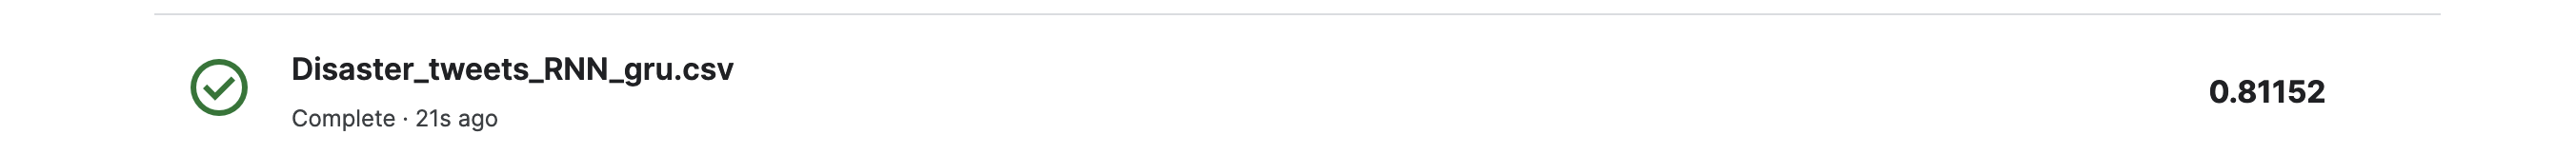

## Step 4: Results and Analysis 


In [23]:
from tensorflow.keras.callbacks import TensorBoard

model = Sequential([])
model.add(layers.Input(shape=(35,100)))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

log_dir = 'tf_model_gru'
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics=['Accuracy'])

model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=30, callbacks=[tensorboard_callback], class_weight=weights, batch_size=512)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - Accuracy: 0.5639 - loss: 1.5175 - val_Accuracy: 0.7566 - val_loss: 0.5090
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - Accuracy: 0.7842 - loss: 0.9594 - val_Accuracy: 0.7833 - val_loss: 0.4672
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - Accuracy: 0.7933 - loss: 0.9042 - val_Accuracy: 0.8104 - val_loss: 0.4425
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - Accuracy: 0.8169 - loss: 0.8274 - val_Accuracy: 0.8122 - val_loss: 0.4328
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - Accuracy: 0.8281 - loss: 0.7867 - val_Accuracy: 0.7885 - val_loss: 0.4702
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - Accuracy: 0.8466 - loss: 0.7219 - val_Accuracy: 0.7890 - val_loss: 0.4732
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - Accuracy: 0.8520 - loss: 0.6713 - val_Accuracy: 0.7999 - val_loss: 0.4557
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - Accuracy: 0.8825 - loss: 0.6105 - val_Accuracy: 0.

TensorBoard for the GRU model:

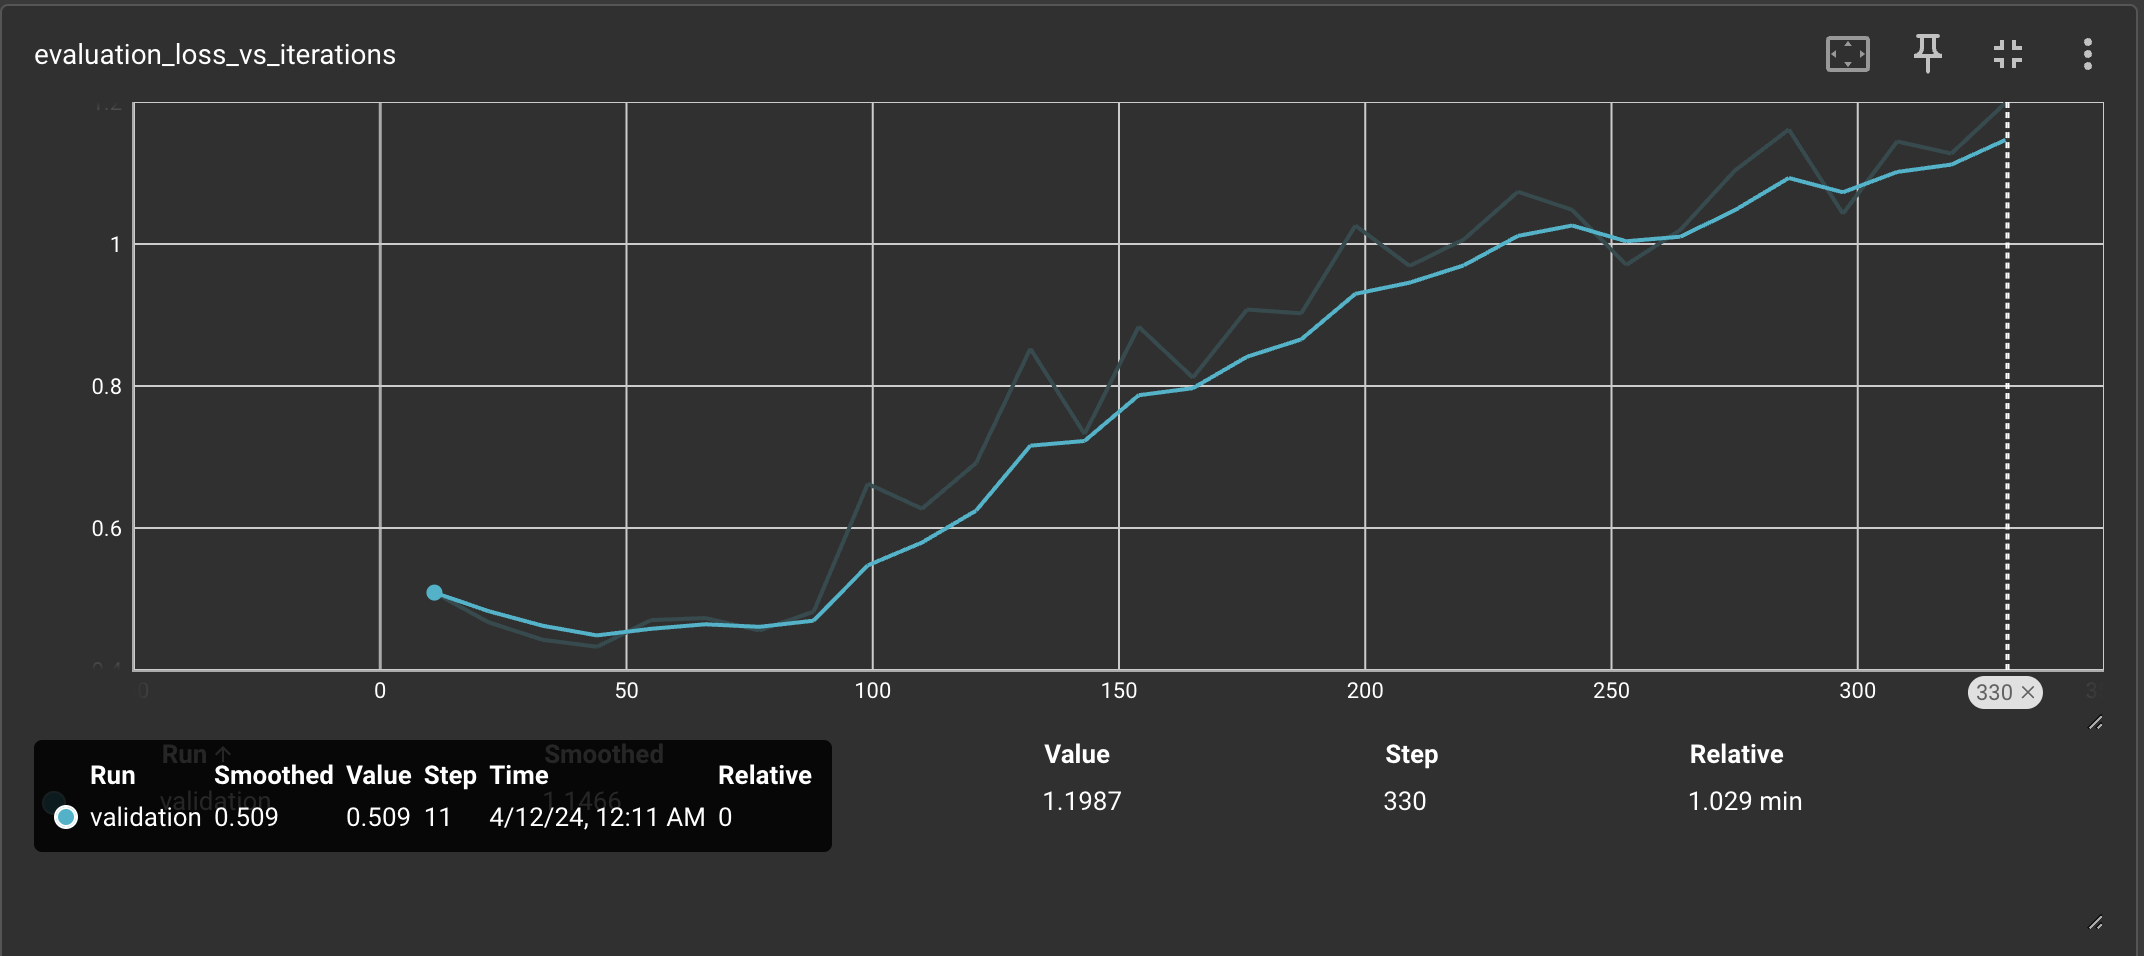

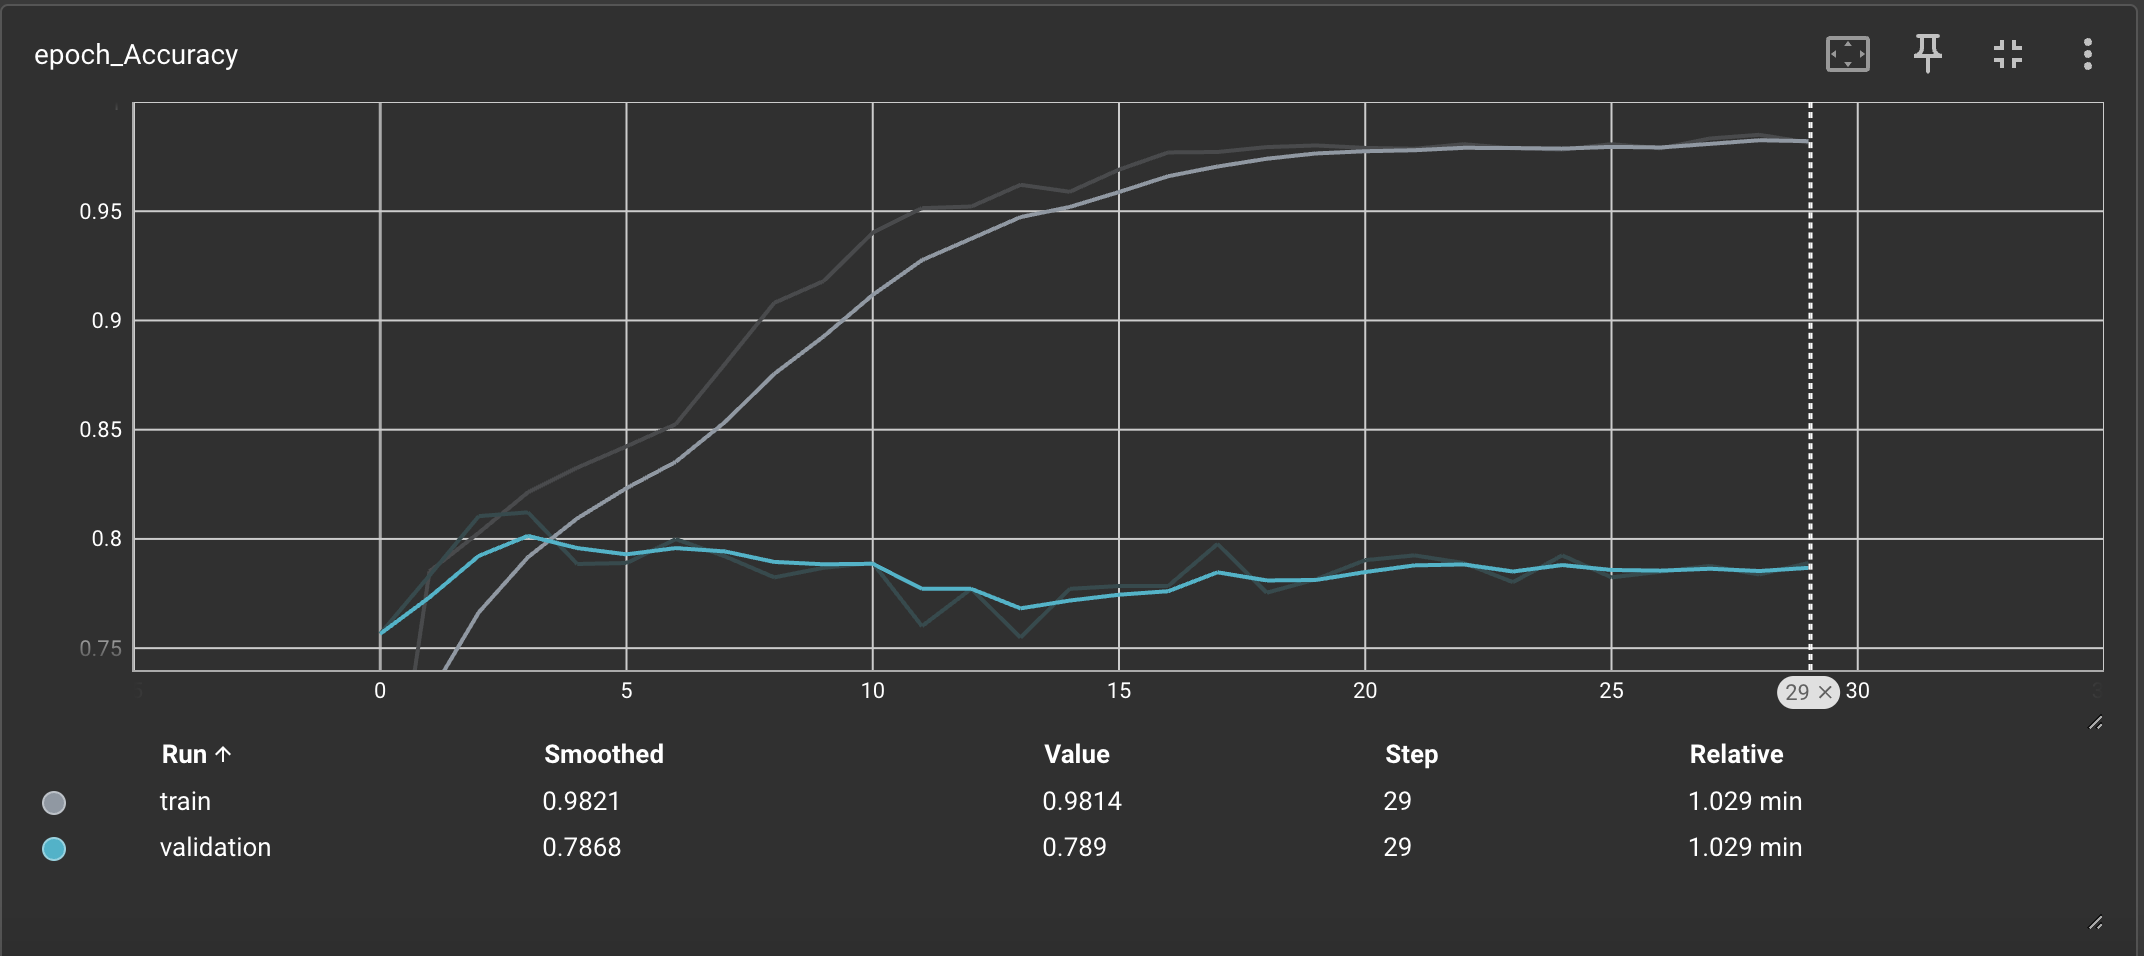

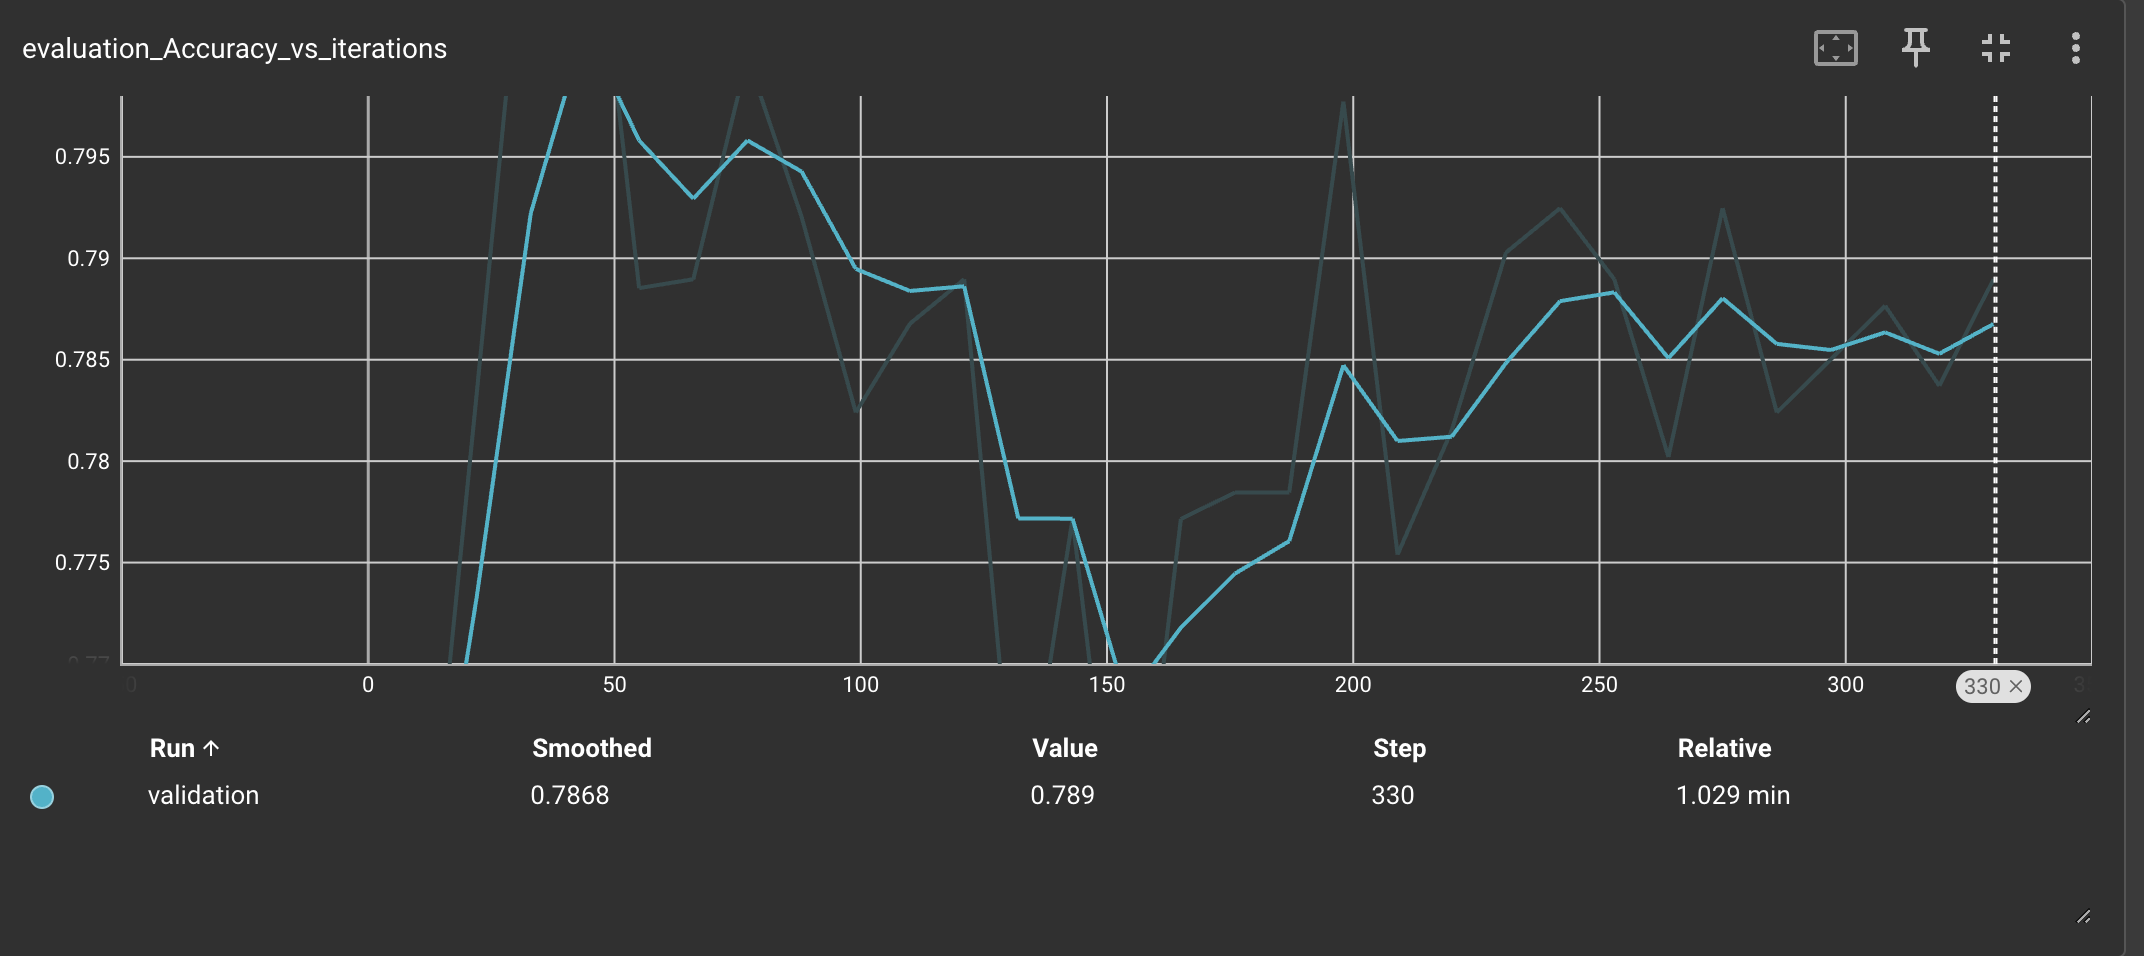


We have explored LSTM and GRU based RNN.  For the models proposed above, the models have returned results between 0.79-0.81.  Due to lack of time, and since the primary expectation from this project is not accuracy, I am settling for these values.

A brief overview of what was attempted:
| RNN family | units  | learning rate| epochs | weights | batch size | metrics | test result |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  LSTM  |  64  | 0.0001 |  20   |  No   |  default  |  ['Accuracy', AUC(name='auc')]    |  0.79773 |
|  LSTM  |  64  | 0.0001 |  20   |  Yes   |  default  |  ['Accuracy', AUC(name='auc')]    |  0.80416 |
|  LSTM  |  128  | 0.0001 |  50   |  Yes   |  default  |  ['Accuracy', AUC(name='auc')]    |  0.80140 |
|  GRU  |  64   |  0.01   |  30   |  Yes   |  512   |  ['Accuracy']   | 0.81152 |

metrics 'Accuracy' works well enough for most cases as has been seen in the results.  I have explored fine tuning hyper-parameters and other values to see how the model reacts for both validation as well as test data.  The values I used for learning rate or epoch does play a role in the accuracy but the results were not with a big margin.

I haven't shown all the models I tried since a few of the tweaks in hyper parameters didn't yield better results.  Some of those models performed worse than the above models.  

Decreasing the learning rate further to 0.00001 didn't help with the accuracy.  epochs at 20 or 50 are also not really much helpful in these models.  I could have probably gotten similar results with a lesser epoch.

## Step 5: Conclusion

##### Results and key learnings

The key learning is that tweaking hyperparameter alone is not enough in many cases.  We need to fine tune the model based on the kind of data that is being used in the models.  We could clean up the data a little more including removal of http links and explore further stop words removal.  While the results are decent, unfortunately I would have been happy if I had come up with a model with a result > 0.9

##### Try in future

I have used only Adam optimizer and would like to try other optimizers to see how they perform for this use case.  I have used GloVe embeddings and would try other word embeddings 

## Step 6: Produce Deliverables

GitHub Repository:
https://github.com/krishnakuruvadi/Week4_RNN

Report:
https://github.com/krishnakuruvadi/Week4_RNN

Kaggle leaderboard:
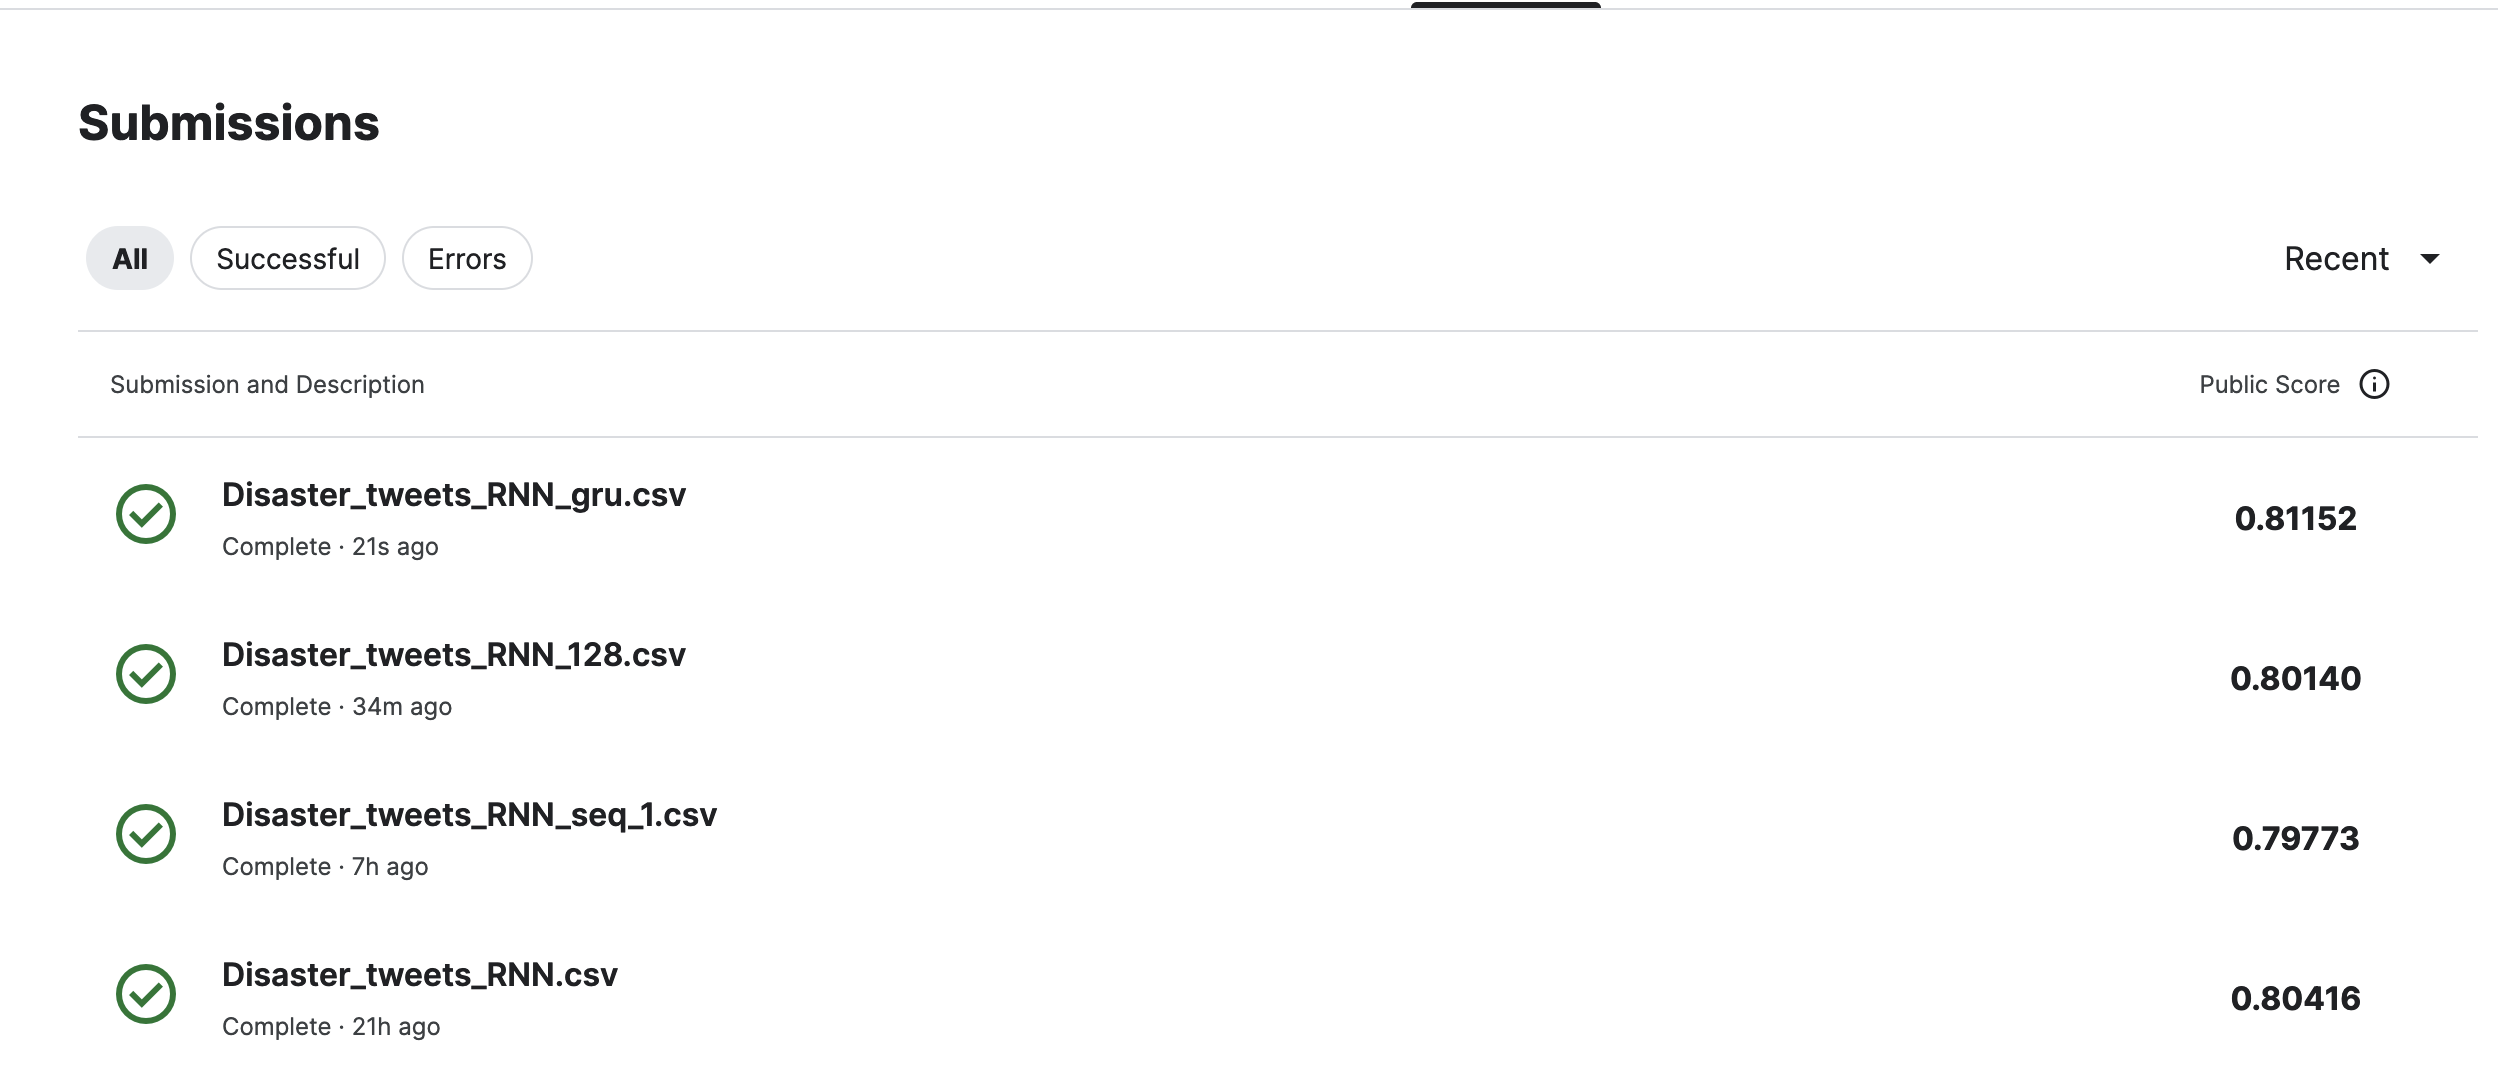